In [19]:
#import required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import re

In [20]:
data = pd.read_csv(r"C:\Users\19712\OneDrive\Desktop\NLP\merged_data.csv")
data.drop('Unnamed: 0', axis = 1, inplace = True)

In [21]:
#cleanup data
text_clean = '@\S+|https?:\S|[^A-Za-z0-9]+'

def clean_text(text, stem=False):
    text = re.sub(text_clean, ' ', str(text).lower()).strip()
    #text = tf.strings.substr(text, 0, 300) #restrict text size to 300 chars
    
    return text

text = data['Text'].apply(lambda x: clean_text(x))
data['Text'] = text

In [22]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Text'])
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

In [23]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size = 0.2)

In [24]:
max_len = np.max([len(text.split()) for text in train_data['Text']])

from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['Text']), 
                       maxlen = 500)

X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['Text']),
                      maxlen = 500)

In [25]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

encoder = LabelEncoder()
encoder.fit(train_data['Sentiment'].to_list())

y_train = encoder.transform(train_data['Sentiment'].to_list())
y_test = encoder.transform(test_data['Sentiment'].to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [26]:
GLOVE_EMB = r"C:\Users\19712\OneDrive\Desktop\NLP\glove.840B.300d\glove.840B.300d.txt"
GLOVE_DIM = 300

In [27]:
embedding_index = {}

f = open(GLOVE_EMB, encoding = 'utf-8')
for line in f:
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype = 'float32')
    embedding_index[word] = coefs
f.close()

In [28]:
embedding_matrix = np.zeros((vocab_size, GLOVE_DIM))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [29]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                           GLOVE_DIM,
                                           weights = [embedding_matrix],
                                           input_length = 500,
                                           trainable = False)

## LSTM Model

In [30]:
# #counting most common words to speed up training time 

# from collections import Counter

# vocabulary = Counter()
# for text in data['Text']:
#     word = text.split()
#     for w in word:
#         vocabulary.update(list(text))

In [31]:
# vocabulary.most_common()[:20]

In [70]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [76]:
#onehot encode classifications 
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [77]:
sequence_input = Input(shape = (500,), dtype = 'int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation = 'relu')(x)
x = Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
outputs = Dense(3, activation = 'softmax')(x)
model = tf.keras.Model(sequence_input, outputs)

In [78]:
LR = 0.001
EPOCHS = 20
BATCH_SIZE = 1024
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer = Adam(learning_rate = LR), loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

ReduceLROnPlateau = ReduceLROnPlateau(factor = 0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [79]:
#subsets to see model performance
X_train_sub, X_test_sub = X_train[:10000], X_test[:2000]
y_train_sub, y_test_sub = y_train[:10000], y_test[:2000]

In [80]:
#history = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                   #validation_data = (X_test, y_test), callbacks = [ReduceLROnPlateau])

In [82]:
history = model.fit(X_train_sub, y_train_sub, batch_size = BATCH_SIZE, epochs = EPOCHS,
                   validation_data = (X_test_sub, y_test_sub), callbacks = [ReduceLROnPlateau])

Epoch 1/20
10/10 [==============================] - 262s 26s/step - loss: 0.7622 - accuracy: 0.7619 - val_loss: 0.7216 - val_accuracy: 0.7710
Epoch 2/20
10/10 [==============================] - 356s 36s/step - loss: 0.6812 - accuracy: 0.7619 - val_loss: 0.6497 - val_accuracy: 0.7710
Epoch 3/20
10/10 [==============================] - 406s 41s/step - loss: 0.6456 - accuracy: 0.7619 - val_loss: 0.6045 - val_accuracy: 0.7710
Epoch 4/20
10/10 [==============================] - 449s 45s/step - loss: 0.6002 - accuracy: 0.7619 - val_loss: 0.5512 - val_accuracy: 0.7710
Epoch 5/20
10/10 [==============================] - 509s 51s/step - loss: 0.5734 - accuracy: 0.7709 - val_loss: 0.5153 - val_accuracy: 0.7930
Epoch 6/20
10/10 [==============================] - 872s 87s/step - loss: 0.5630 - accuracy: 0.7796 - val_loss: 0.5311 - val_accuracy: 0.7975
Epoch 7/20
10/10 [==============================] - 812s 81s/step - loss: 0.5281 - accuracy: 0.7900 - val_loss: 0.5141 - val_accuracy: 0.7915
Epoch 

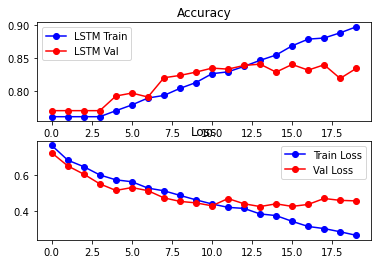

In [83]:
import matplotlib.pyplot as plt

s, (acc, loss) = plt.subplots(2,1)
acc.plot(history.history['accuracy'], c = 'b', marker = 'o')
acc.plot(history.history['val_accuracy'], c = 'r', marker = 'o')
acc.set_title('Accuracy')
acc.legend(['LSTM Train', 'LSTM Val'], loc = 'best')

loss.plot(history.history['loss'], c = 'b', marker = 'o')
loss.plot(history.history['val_loss'], c = 'r', marker = 'o')
loss.set_title('Loss')
loss.legend(['Train Loss', 'Val Loss'], loc = 'best')

Diminishing returns around 10 epochs.

In [84]:
scores = model.predict(X_test, verbose = 1, batch_size = 1000)

67/67 [==============================] - 1514s 23s/step


In [182]:
y_pred = np.argmax(scores,axis=1).reshape(-1,1)

In [139]:
#Probability that corresponds to each class 
classes = encoder.classes_

array(['negative', 'neutral', 'positive'], dtype='<U8')

In [191]:
y_test_compare = np.argmax(y_test, axis = 1).reshape(-1,1)

In [194]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

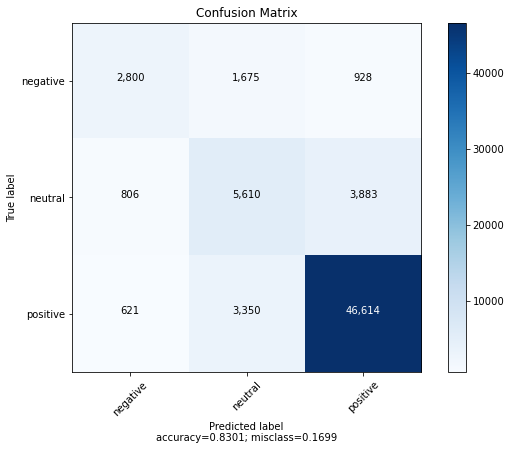

In [195]:
plot_confusion_matrix(cm           = np.array([[ 2800,  1675,   928],
                                              [  806,  5610,  3883],
                                              [  621,  3350, 46614]]), 
                      normalize    = False,
                      target_names = ['negative', 'neutral', 'positive'],
                      title        = "Confusion Matrix")

In [193]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_compare, y_pred)

array([[ 2800,  1675,   928],
       [  806,  5610,  3883],
       [  621,  3350, 46614]], dtype=int64)